Available stations:
1. Stuttgart
2. Frankfurt
3. Hannover
4. Hamburg
5. Berlin

Available years:
1. 2015
2. 2016
3. 2017
4. 2018
5. 2019
6. 2020
7. 2021
8. 2022
9. 2023
10. 2024

Most correlated cargo with revenue: Cereals (|r| = 0.9442)
Regression model: Revenue = 115.16 + 0.49 * Cereals
Sum of squared errors (SQE): 27247.59

Forecasted revenue for January next year with 10% more Cereals: 592.84
95% Confidence Interval: [442.64, 743.03]


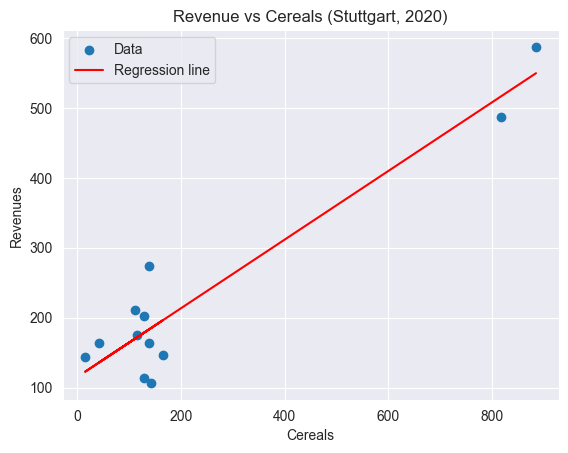

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# === Load and preprocess data ===
df = pd.read_csv("../../../datasets/stations-data.csv", sep=';')

# Convert European number formats to floats
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = df[col].str.replace(',', '.', regex=False).astype(float)
        except:
            pass  # Skip columns that can't be converted (e.g., Station, Month)

# === Step 1: User selects station from numbered list ===
stations = df['Station'].unique()
print("Available stations:")
for idx, station in enumerate(stations, start=1):
    print(f"{idx}. {station}")

station_index = int(input(f"\nEnter a number (1 to {len(stations)}): ")) - 1
station_input = stations[station_index]

# === Step 2: User inputs year ===
years = sorted(df['Year'].unique())
print("\nAvailable years:")
for idx, year in enumerate(years, start=1):
    print(f"{idx}. {year}")

year_index = int(input(f"\nEnter a number (1 to {len(years)}): ")) - 1
year_input = years[year_index]

# === Step 3: Filter data ===
filtered_df = df[(df['Station'] == station_input) & (df['Year'] == year_input)]

# === Step 4: Correlation analysis ===
cargo_columns = ['Iron', 'Coal', 'Steel', 'Vegetables', 'Cereals', 'Wool', 'Coffee', 'Cattle']
correlations = {}

for cargo in cargo_columns:
    if filtered_df[cargo].std() > 0:
        r, _ = stats.pearsonr(filtered_df[cargo], filtered_df['Revenues'])
        correlations[cargo] = abs(r)

best_cargo = max(correlations, key=correlations.get)
print(f"\nMost correlated cargo with revenue: {best_cargo} (|r| = {correlations[best_cargo]:.4f})")

# === Step 5: Linear regression ===
x = filtered_df[best_cargo].values
y = filtered_df['Revenues'].values
n = len(x)

x_mean, y_mean = np.mean(x), np.mean(y)
Sxx = np.sum((x - x_mean) ** 2)
Syy = np.sum((y - y_mean) ** 2)
Sxy = np.sum((x - x_mean) * (y - y_mean))

beta1 = Sxy / Sxx
beta0 = y_mean - beta1 * x_mean

# === Step 6: Predictions and residuals ===
y_hat = beta0 + beta1 * x
residuals = y - y_hat
sqe = np.sum(residuals ** 2)
s2 = sqe / (n - 2)
print(f"Regression model: Revenue = {beta0:.2f} + {beta1:.2f} * {best_cargo}")
print(f"Sum of squared errors (SQE): {sqe:.2f}")

# === Step 7: Forecast for next January ===
jan_df = df[(df['Station'] == station_input) & (df['Year'] == year_input) & (df['Month'] == 1)]
if jan_df.empty:
    raise ValueError("January data not found.")

x_jan = jan_df[best_cargo].values[0]
x_forecast = x_jan * 1.10
y_forecast = beta0 + beta1 * x_forecast

# === Step 8: 95% confidence interval for prediction ===
t_value = stats.t.ppf(0.975, df=n-2)
conf_margin = t_value * np.sqrt(s2 * (1 + 1/n + ((x_forecast - x_mean) ** 2) / Sxx))
lower_bound = y_forecast - conf_margin
upper_bound = y_forecast + conf_margin

print(f"\nForecasted revenue for January next year with 10% more {best_cargo}: {y_forecast:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

# === Plot the regression ===
plt.scatter(x, y, label='Data')
plt.plot(x, y_hat, color='red', label='Regression line')
plt.xlabel(best_cargo)
plt.ylabel('Revenues')
plt.title(f'Revenue vs {best_cargo} ({station_input}, {year_input})')
plt.legend()
plt.grid(True)
plt.show()
